In [1]:
import os.path as path
import os

import numpy as np
import pandas as pd
from PIL import Image, ImageOps

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch as t

from training_meta import calc_meta

In order to use the CrossEntropyLoss I need each example in `(tensor, k)` shape, where $k \in {0, 3}$ to represent the four classes we have - rust, scab, healthy, multiple_diseases. It is best to write my own `Dataset` which will load all the train/test images and then will iterate through them based on the `train.csv` provided.

In [2]:
RUST = 0
SCAB = 1
HEALTHY = 2
MULTIPLE_DISEASES = 3
DATAROOT = path.expanduser("~/ml-data/plant-pathology")


In [3]:
imgroot = path.join(DATAROOT, "cache", "250x250")

In [4]:
calc_meta(imgroot)

Means:  0.4038582976214318 0.5127894672998029 0.3129764558236694
Stds:  0.2034616086724042 0.18909514150453344 0.18761408366900625


In [5]:
# This has been moved to its own Python module for ease of use in experiments

class PlantPathologyDataset(Dataset):
    def __init__(self, imgroot, transformer=None, train=True):
        self._xform = transformer
        self._imgroot = imgroot

        train_df = pd.read_csv(path.join(DATAROOT, "train.csv"))
        self._image_ids = []
        self._labels = []

        for row in train_df.itertuples():
            self._image_ids.append(row.image_id)
            if row.rust == 1:
                self._labels.append(RUST)
            elif row.scab == 1:
                self._labels.append(SCAB)
            elif row.healthy == 1:
                self._labels.append(HEALTHY)
            elif row.multiple_diseases:
                self._labels.append(MULTIPLE_DISEASES)
            else:
                raise RuntimeError(f"Unknown label!! {row}")

    def __getitem__(self, idx):
        img_file = f"{self._image_ids[idx]}.jpg"
        img_path = path.join(self._imgroot, img_file)
        img = Image.open(img_path)
        if self._xform is not None:
            img = self._xform(img)
        return img, self._labels[idx]
        

    def __len__(self):
        return len(self._labels)

In [6]:
means = (0.4038582976214318, 0.5127894672998029, 0.3129764558236694)
stds = (0.2034616086724042, 0.18909514150453344, 0.18761408366900625)
xform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])
ds = PlantPathologyDataset(imgroot, xform)

In [7]:
ds[0]

(tensor([[[-1.2140, -1.2332, -1.1947,  ..., -0.9249, -1.0212, -1.0212],
          [-1.2525, -1.2525, -1.2140,  ..., -0.9634, -1.0212, -1.0212],
          [-1.2911, -1.3103, -1.2911,  ..., -1.0019, -1.0405, -1.0405],
          ...,
          [ 1.5423,  1.5423,  1.5423,  ...,  1.9470,  1.6772,  1.7157],
          [ 1.5230,  1.5230,  1.5230,  ...,  1.7928,  1.6193,  1.7543],
          [ 1.5230,  1.5230,  1.5230,  ...,  1.7928,  1.6964,  1.8314]],
 
         [[-1.6749, -1.6749, -1.6127,  ..., -1.3638, -1.4675, -1.4675],
          [-1.6956, -1.6956, -1.6334,  ..., -1.3845, -1.4468, -1.4468],
          [-1.7371, -1.6956, -1.6749,  ..., -1.4260, -1.4675, -1.4675],
          ...,
          [ 0.8967,  0.8967,  0.8345,  ...,  1.7055,  1.4152,  1.4774],
          [ 0.8138,  0.8138,  0.7723,  ...,  1.5396,  1.3530,  1.4981],
          [ 0.8138,  0.8138,  0.7723,  ...,  1.5396,  1.4359,  1.5811]],
 
         [[-1.3338, -1.3338, -1.3129,  ..., -1.0202, -1.1247, -1.1247],
          [-1.3547, -1.3547,

In [8]:
ds[0][0].shape

torch.Size([3, 250, 250])

In [9]:
img = ds[0][0]

In [10]:
rescaled_red = ((img[0] * stds[0]) + means[0]) * 255
rescaled_green = ((img[1] * stds[1]) + means[1]) * 255
rescaled_blue = ((img[2] * stds[2]) + means[2]) * 255
rescaled_img = t.stack((rescaled_red, rescaled_green, rescaled_blue)).permute(1, 2, 0).to(t.uint8)

In [11]:
rescaled_img.shape

torch.Size([250, 250, 3])

In [12]:
rescaled_img[:, :, 0]

tensor([[ 40,  38,  41,  ...,  55,  50,  50],
        [ 37,  37,  40,  ...,  53,  50,  50],
        [ 35,  34,  35,  ...,  50,  49,  49],
        ...,
        [183, 183, 183,  ..., 204, 190, 192],
        [182, 182, 182,  ..., 196, 187, 194],
        [182, 182, 182,  ..., 196, 191, 198]], dtype=torch.uint8)

In [13]:
imgpath = path.expanduser("~/ml-data/plant-pathology/cache/250x250/Train_0.jpg")
orig_img = np.asarray(Image.open(imgpath))

In [14]:
orig_img.shape

(250, 250, 3)

In [15]:
orig_img[:, :, 0]

array([[ 40,  39,  41, ...,  55,  50,  50],
       [ 38,  38,  40, ...,  53,  50,  50],
       [ 36,  35,  36, ...,  51,  49,  49],
       ...,
       [183, 183, 183, ..., 204, 190, 192],
       [182, 182, 182, ..., 196, 187, 194],
       [182, 182, 182, ..., 196, 191, 198]], dtype=uint8)

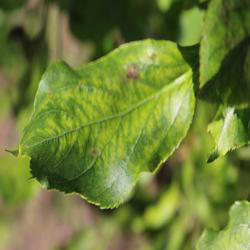

In [16]:
Image.fromarray(rescaled_img.numpy())

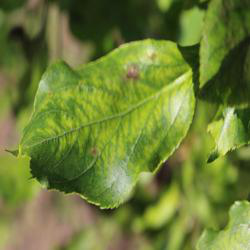

In [17]:
Image.fromarray(orig_img)

In [18]:
rescaled_img[:, :, 1]

tensor([[ 49,  49,  52,  ...,  65,  59,  59],
        [ 48,  48,  51,  ...,  64,  60,  60],
        [ 46,  48,  49,  ...,  61,  59,  59],
        ...,
        [174, 174, 171,  ..., 213, 199, 202],
        [170, 170, 168,  ..., 205, 196, 203],
        [170, 170, 168,  ..., 205, 200, 207]], dtype=torch.uint8)

In [19]:
orig_img[:, :, 1]

array([[ 50,  50,  53, ...,  65,  60,  60],
       [ 49,  49,  52, ...,  64,  61,  61],
       [ 47,  49,  50, ...,  62,  60,  60],
       ...,
       [174, 174, 171, ..., 213, 199, 202],
       [170, 170, 168, ..., 205, 196, 203],
       [170, 170, 168, ..., 205, 200, 207]], dtype=uint8)

In [20]:
rescaled_img[:, :, 2]

tensor([[ 15,  15,  16,  ...,  30,  25,  25],
        [ 14,  14,  15,  ...,  30,  27,  27],
        [ 12,  13,  14,  ...,  27,  25,  25],
        ...,
        [117, 119, 119,  ..., 166, 152, 152],
        [118, 118, 121,  ..., 160, 151, 156],
        [120, 122, 123,  ..., 160, 155, 162]], dtype=torch.uint8)

In [21]:
orig_img[:, :, 2]

array([[ 16,  16,  17, ...,  31,  26,  26],
       [ 15,  15,  16, ...,  30,  27,  27],
       [ 13,  14,  15, ...,  28,  26,  26],
       ...,
       [117, 119, 119, ..., 166, 152, 152],
       [118, 118, 121, ..., 160, 151, 156],
       [120, 122, 123, ..., 160, 155, 162]], dtype=uint8)

In [22]:
img[0]

tensor([[-1.2140, -1.2332, -1.1947,  ..., -0.9249, -1.0212, -1.0212],
        [-1.2525, -1.2525, -1.2140,  ..., -0.9634, -1.0212, -1.0212],
        [-1.2911, -1.3103, -1.2911,  ..., -1.0019, -1.0405, -1.0405],
        ...,
        [ 1.5423,  1.5423,  1.5423,  ...,  1.9470,  1.6772,  1.7157],
        [ 1.5230,  1.5230,  1.5230,  ...,  1.7928,  1.6193,  1.7543],
        [ 1.5230,  1.5230,  1.5230,  ...,  1.7928,  1.6964,  1.8314]])

In [23]:
img[1]

tensor([[-1.6749, -1.6749, -1.6127,  ..., -1.3638, -1.4675, -1.4675],
        [-1.6956, -1.6956, -1.6334,  ..., -1.3845, -1.4468, -1.4468],
        [-1.7371, -1.6956, -1.6749,  ..., -1.4260, -1.4675, -1.4675],
        ...,
        [ 0.8967,  0.8967,  0.8345,  ...,  1.7055,  1.4152,  1.4774],
        [ 0.8138,  0.8138,  0.7723,  ...,  1.5396,  1.3530,  1.4981],
        [ 0.8138,  0.8138,  0.7723,  ...,  1.5396,  1.4359,  1.5811]])

In [24]:
img[2]

tensor([[-1.3338, -1.3338, -1.3129,  ..., -1.0202, -1.1247, -1.1247],
        [-1.3547, -1.3547, -1.3338,  ..., -1.0411, -1.1038, -1.1038],
        [-1.3965, -1.3756, -1.3547,  ..., -1.0829, -1.1247, -1.1247],
        ...,
        [ 0.7774,  0.8192,  0.8192,  ...,  1.8016,  1.5090,  1.5090],
        [ 0.7983,  0.7983,  0.8610,  ...,  1.6762,  1.4881,  1.5926],
        [ 0.8401,  0.8819,  0.9028,  ...,  1.6762,  1.5717,  1.7180]])